### Simple model without horizon and location
$y_t \mid \varepsilon_t = \theta + \sum_{p=1} \phi_p y_{t-p} + \varepsilon_t, \\
\varepsilon_t \sim N(0, \sigma_{\eta}) $


In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
# import seaborn as sns
from datetime import date

import jax
import jax.numpy as jnp

import arviz as az


In [2]:
from arh_simpler import ARHDFA

/Users/elray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def loaddata(model1, model2, val, mean_axis):
    mypath = f'../Data/death_diff_scores/{model1}_{model2}.csv'
    df = pd.read_csv(mypath)
    lix = pd.MultiIndex.from_product([np.unique(df.location), np.unique(df.relative_horizon)])
    df_pivot = (df.pivot_table(val, 'reference_date', ['location', 'relative_horizon'], aggfunc='first')).reindex(lix, axis=1)
    mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
    if model1 == 'COVIDhub-baseline' or model2 == 'COVIDhub-baseline':
        indices_to_change = [(38, 13), (21, 24), (24, 41)]
        for index in indices_to_change:
            mydf = mydf.at[index[0], index[1], :].set(np.nan) 
        print(mydf[38,13,:])
    if mean_axis == 'location':
        mydf_mean = np.mean(mydf, axis=1)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,mydf_mean.shape[1])
    elif mean_axis == 'horizon':
        mydf_mean = np.mean(mydf, axis=2)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],mydf_mean.shape[1],1)
    elif mean_axis == 'both':
        mydf_mean = np.mean(mydf, axis=(1,2))
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,1)
    else:  mydf_reshape = mydf[:,0,0].reshape(mydf.shape[0],1,1)

    return mydf_reshape

In [4]:
def dfa_ftn(model1, model2, val, mean_axis, p=1, q=1, sigma_time = 'constant', 
            ar_constraint='[0,1]', ar_var_constraint='[0,1]'):
    obs = loaddata(model1, model2, val, mean_axis)
    # Define a DFA model with specified parameter values to use for data generation
    dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                        p=p, q=q, ar_constraint=ar_constraint, sigma_time=sigma_time,
                        ar_var_constraint=ar_var_constraint)
    mcmc_samples = dfa_model.fit(y=obs,
                             rng_key=jax.random.PRNGKey(79942),
                             num_warmup=5000,
                             num_samples=5000,
                             thinning = 1,
                             num_chains=3)
    dfa_model.mcmc.print_summary()
    waic = az.waic(az.from_numpyro(mcmc_samples))
    print(waic)
    az.plot_pair(az.from_numpyro(mcmc_samples),
            #var_names=['intercept', 'alpha', 'phi','ARVar_mu'],
            divergences=True,
            colorbar=True)
    az.plot_trace(az.from_numpyro(mcmc_samples))




[nan nan nan nan]


/Users/elray/research/epi/methods/Comparing-Forecast-Performance/DFA/arh_simpler.py:326: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 10000/10000 [00:05<00:00, 1946.84it/s, 15 steps of size 1.15e-01. acc. prob=0.91]



MCMC elapsed time: 26.041165113449097

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
      a_sigma_eps     -0.02      0.10     -0.02     -0.19      0.13   4229.53      1.00
      b_sigma_eps      0.96      0.09      0.96      0.79      1.11   2680.40      1.00
     intercept[0]    -13.09      5.92    -13.68    -22.24     -3.61    241.43      1.01
    log_sigma_eps      1.54      0.17      1.54      1.26      1.81   2138.83      1.00
  log_sigma_eta_t      1.67      0.15      1.66      1.42      1.91   2307.88      1.00
       m_t[0,0,0]      5.03      5.27      5.15     -3.75     13.32    397.04      1.00
       m_t[1,0,0]      5.00      6.29      5.25     -5.69     14.82    333.57      1.00
       m_t[2,0,0]      1.49      6.59      1.82     -9.34     12.11    323.89      1.00
       m_t[3,0,0]     -3.82      6.67     -3.52    -14.26      7.42    320.15      1.00
       m_t[4,0,0]     -9.85      6.70     -9.39    -20.78      0.84    312.41   

/Users/elray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 39 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -123.78     2.94
p_waic       14.76        -

There has been a warning during the calculation. Please check the results.


/Users/elray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: title={'center': 'a_sigma_eps'}>,
        <Axes: title={'center': 'a_sigma_eps'}>],
       [<Axes: title={'center': 'b_sigma_eps'}>,
        <Axes: title={'center': 'b_sigma_eps'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'log_sigma_eps'}>,
        <Axes: title={'center': 'log_sigma_eps'}>],
       [<Axes: title={'center': 'log_sigma_eta_t'}>,
        <Axes: title={'center': 'log_sigma_eta_t'}>],
       [<Axes: title={'center': 'm_t'}>, <Axes: title={'center': 'm_t'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'y_0'}>, <Axes: title={'center': 'y_0'}>]],
      dtype=object)

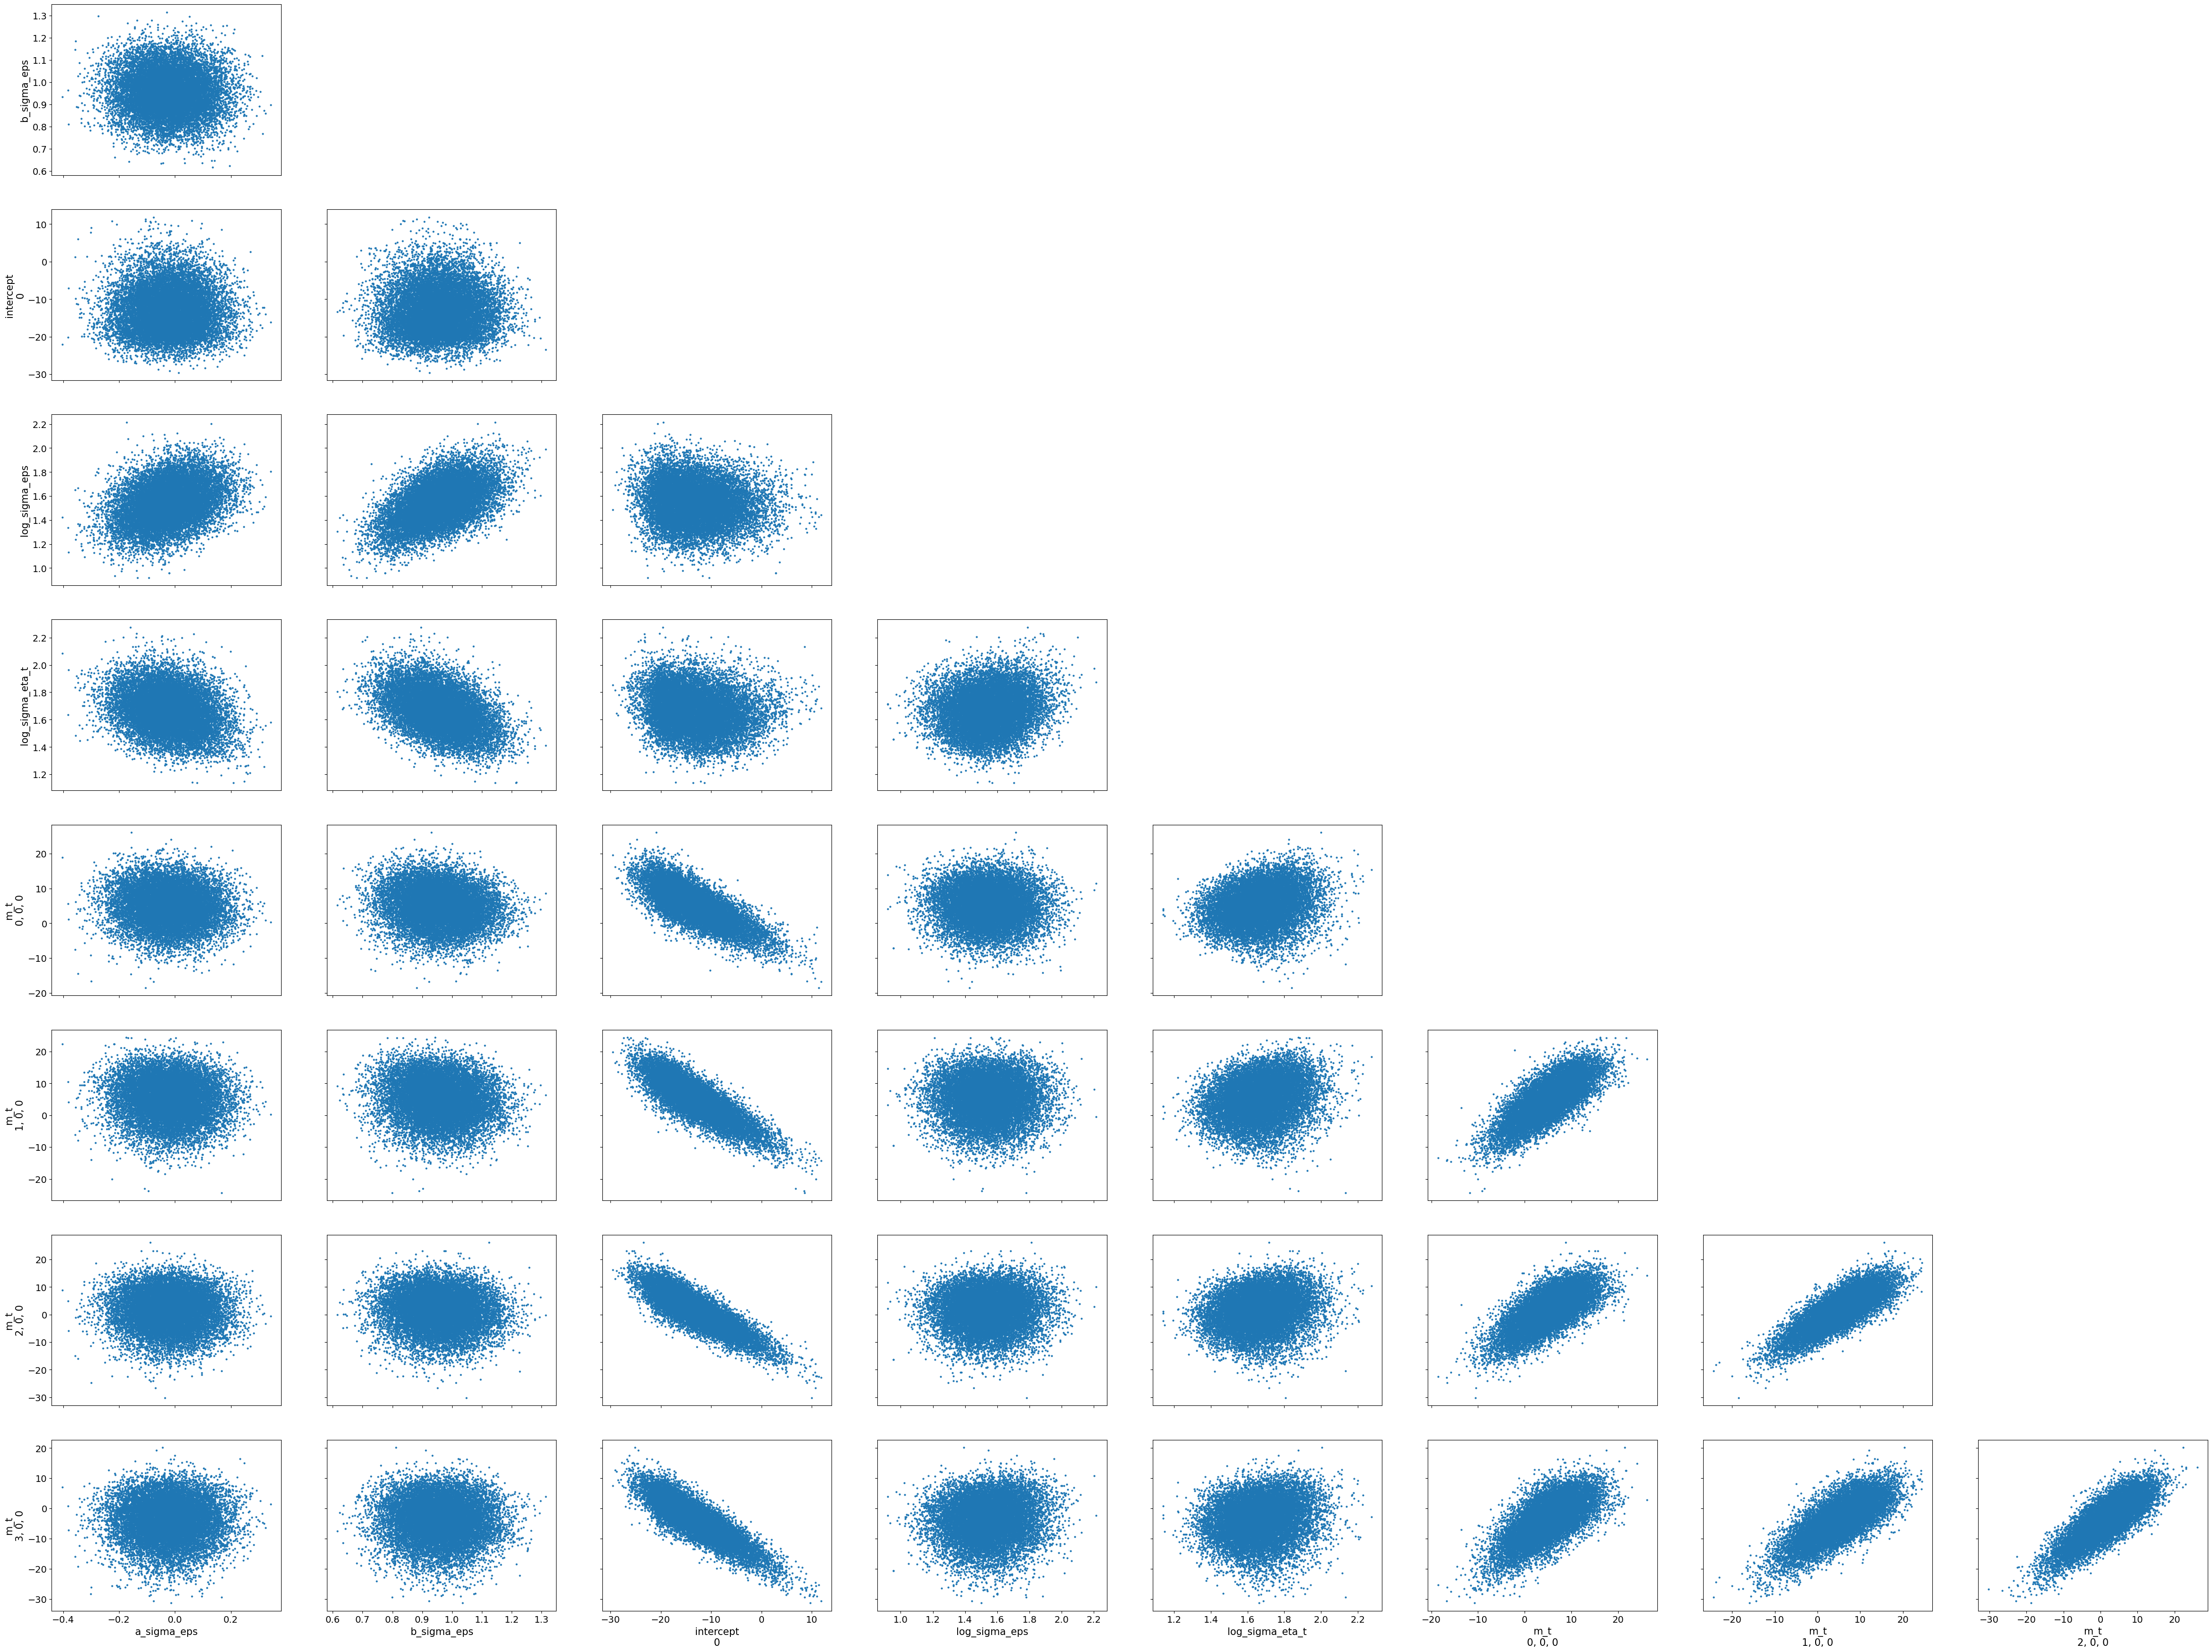

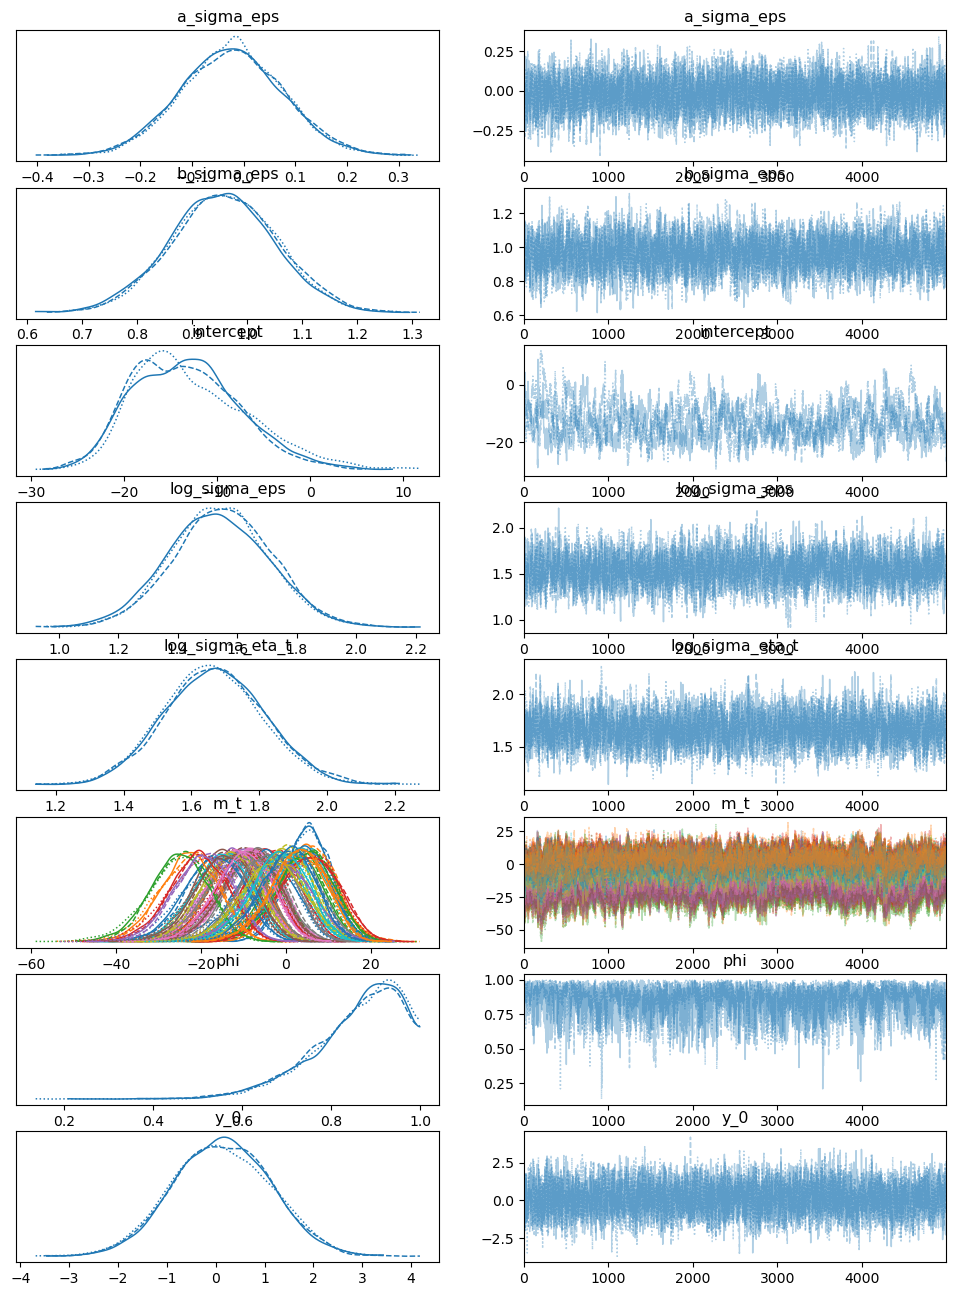

In [5]:
model1 = 'COVIDhub-4_week_ensemble'
model2 = 'COVIDhub-baseline'
val = 'diff'
mean_axis = 'both'
p=1
q=1
ar_constraint='[0,1]'
ar_var_constraint='[0,1]'
sigma_time = 'constant'

obs = loaddata(model1, model2, val, mean_axis)
# Define a DFA model with specified parameter values to use for data generation
dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                    p=p, q=q, ar_constraint=ar_constraint, sigma_time=sigma_time,
                    ar_var_constraint=ar_var_constraint)
mcmc_samples = dfa_model.fit(y=obs,
                            rng_key=jax.random.PRNGKey(79942),
                            num_warmup=5000,
                            num_samples=5000,
                            thinning = 1,
                            num_chains=3)

dfa_model.mcmc.print_summary()
waic = az.waic(az.from_numpyro(mcmc_samples))
print(waic)
az.plot_pair(az.from_numpyro(mcmc_samples),
        #var_names=['intercept', 'alpha', 'phi','ARVar_mu'],
        divergences=True,
        colorbar=True)
az.plot_trace(az.from_numpyro(mcmc_samples))


In [ ]:
model1 = 'COVIDhub-4_week_ensemble'
model2 = 'COVIDhub-baseline'
val = 'diff'
mean_axis = 'both'
p=4
q=1
ar_constraint='[0,1]'
ar_var_constraint='[0,1]'
sigma_time = 'constant'

obs = loaddata(model1, model2, val, mean_axis)
# Define a DFA model with specified parameter values to use for data generation
dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                    p=p, q=q, ar_constraint=ar_constraint, sigma_time=sigma_time,
                    ar_var_constraint=ar_var_constraint)
mcmc_samples = dfa_model.fit(y=obs,
                            rng_key=jax.random.PRNGKey(79942),
                            num_warmup=5000,
                            num_samples=5000,
                            thinning = 1,
                            num_chains=3)

dfa_model.mcmc.print_summary()
waic = az.waic(az.from_numpyro(mcmc_samples))
print(waic)
az.plot_pair(az.from_numpyro(mcmc_samples),
        #var_names=['intercept', 'alpha', 'phi','ARVar_mu'],
        divergences=True,
        colorbar=True)
az.plot_trace(az.from_numpyro(mcmc_samples))


In [ ]:
np.std(samples['log_sigma_eps'])

In [ ]:
samples = mcmc_samples.get_samples()
keys = list(samples.keys())
print(keys)

# Iterate through the keys and print the shape of each corresponding array
for key in keys:
    print(samples[key].shape)

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=3, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=4, q=1, sigma_type = 'constant', ar_constraint='[-1,1]')

## sigma_type = 'AR'

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_type = 'AR')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_type = 'AR', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=2, sigma_type = 'AR', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=2, sigma_type = 'AR')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=4, q=1, sigma_type = 'AR', ar_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=2, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=3, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')

In [ ]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=4, 
        sigma_type = 'AR', ar_constraint='[-1,1]', ar_var_constraint='[-1,1]')